In [ ]:
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
sns.set()
rcParams['figure.figsize'] = 10, 6
%config InlineBackend.figure_format = 'svg'
np.random.seed(42)

import random as rand

The function 'converts' 1-day returns series to 10-days returns series. The idea is that we use given recursive formulas to get a new one for 10-days series.
> $r^1_i = \frac{P_{i+1} - P_i} {P_i}$ <br>
> $r^n_i = \frac{P_{i+n} - P_i} {P_i}$ <br>
 
 
$r^n_1 + 1 = \frac{P_{1+n}} {P_1}$ (1) <br>
but $r^1_n + 1 = \frac{P_{n+1}} {P_n}$ <br>
where $P_{n+1} = (r^1_n + 1) * P_n$ (2) <br>
so $r^n_1 + 1 = \frac{(r^1_n + 1) * P_n}{P_1}$ <br>

and so on until $P_1$ and $P_1$ cancel each other out <br>

$r^n_1 + 1 = \frac{(r^1_n + 1) * P_n}{P_1}$ <br>
... <br>
$r^n_i + 1 = \prod_{k=0}^{n-1} (r^i_{n-k} + 1)$

In [ ]:
def calculate_returns_10days(returns_1day):
  '''
  Calculate 10-day returns out of 1-day returns
    :param returns_1day: 1-dimensional numpy array of 1-day returns
    :return: 1-dimensional numpy array of 10-day returns
  '''
  num_of_days = 10
  returns_1day += 1                       
  steps = len(returns_1day) - (num_of_days - 1)
  returns_10days = np.zeros(steps)
  for i in range(steps):
    arr_of_1day_returns = returns_1day[i:i + num_of_days]
    returns_10days[i] = np.prod(arr_of_1day_returns) - 1

  return returns_10days

Firstly, we generate 1-day returns using stable distribution with given parameters (alpha = 1.7, beta = 0, gamma = 1.0, delta = 1.0) and then we calculate percentile of 0.01 based on the distribution.

In [ ]:
def calc_percentile(parameters, size, p):
  '''
    The function calculates percentile value
    :param parameters: stable distribution parameters (alpha,beta,gamma,delta)
    :param size: size of timeseries of 1-day returns
    :param p: percentile value
    :return: calculated percentile
  '''
  returns_1day_list = stats.levy_stable.rvs(*parameters, size=size)
  returns_10days_list = calculate_returns_10days(returns_1day_list)
  percentile = np.percentile(returns_10days_list, p)
  return percentile

In [ ]:
                                        #shape parameters
alpha = 1.7 
beta = 0.

gamma = 1.                              #scale parameter
delta = 1.                              #location parameter

parameters = alpha, beta, gamma, delta
size = 750                              #number of days
p = 1

Here we make Monte-Carlo simulation for generating distribution of 0.01 quantile. The algorithm compares two percentile distributions. Once it finds pvalue and min_dstat so that they satisfy the condition the algorithm is over.

In [ ]:
percentiles1_list, percentiles2_list = [], []
a = 0
itrs = 0
dstat = np.inf #
min_dstat = 0.015                                                     #minimum KS test statistic
while a < 0.5 or dstat > min_dstat:                                   #significance level value is 0.5
  percentile1 = calc_percentile(parameters, size, p)
  percentile2 = calc_percentile(parameters, size, p)

  percentiles1_list.append(percentile1)
  percentiles2_list.append(percentile2)

  if (itrs + 1) % 10 == 0:
    dstat, a = stats.ks_2samp(percentiles1_list,percentiles2_list)    #Tests if 2 samples were drawn from the same distribution

  itrs += 1                                                           #Count of simulations

In [ ]:
results = percentiles1_list + percentiles2_list
itrs

4290

the number of iterations needed to succesfully find the distribution is the variable **itrs** with given significance value and KS test statistic

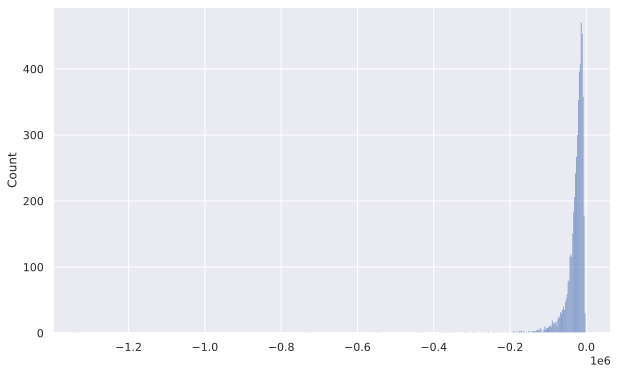

In [ ]:
sns.histplot(x=results);